# LSTM

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'pytorch using: {device}')

pytorch using: cuda


## 數據來源

使用 Yahoo Finance API 獲取股票數據

獲取 **2357華碩** 的五年股價數據

期間：2019/11/19 ～ 2024/11/18

In [3]:
import yfinance as yf
import pandas as pd

five_years_data = yf.download('2357.TW', period='5y')

# 重新命名列
five_years_data.reset_index(inplace=True)  # 將索引重置，將日期作為普通列
five_years_data.columns = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]

print(five_years_data.head())

[*********************100%***********************]  1 of 1 completed

        Date        Open   High    Low  Close  Adj Close   Volume
0 2019-12-09  160.636536  230.5  231.5  229.5      231.0   644718
1 2019-12-10  162.727249  233.5  233.5  230.0      232.0  1191233
2 2019-12-11  161.333420  231.5  233.5  230.0      233.5  1194495
3 2019-12-12  162.378799  233.0  234.5  231.0      231.5  1964332
4 2019-12-13  162.727249  233.5  234.5  231.5      233.0  1231128


In [4]:
# 將日期轉換為datetime格式
df = five_years_data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-09,160.636536,230.5,231.5,229.5,231.0,644718
2019-12-10,162.727249,233.5,233.5,230.0,232.0,1191233
2019-12-11,161.333420,231.5,233.5,230.0,233.5,1194495
2019-12-12,162.378799,233.0,234.5,231.0,231.5,1964332
2019-12-13,162.727249,233.5,234.5,231.5,233.0,1231128
...,...,...,...,...,...,...
2024-12-03,595.000000,595.0,612.0,586.0,610.0,5233289
2024-12-04,601.000000,601.0,603.0,592.0,594.0,3095580
2024-12-05,600.000000,600.0,608.0,596.0,600.0,3607276


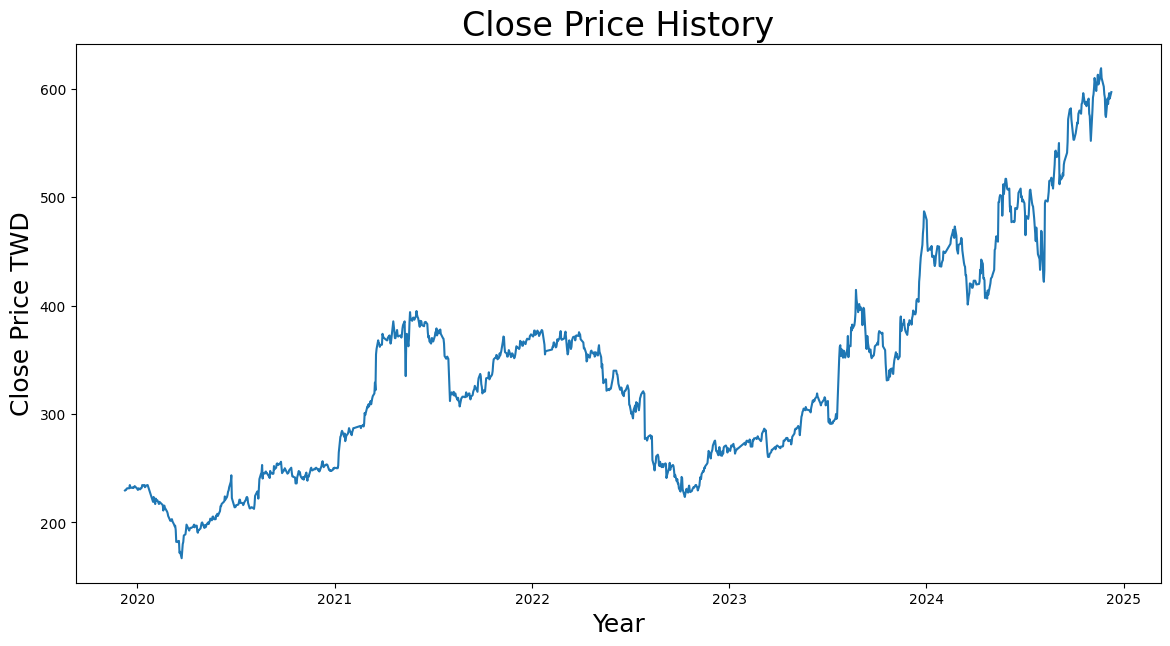

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.title('Close Price History', fontsize=24)
plt.plot(df['Close'])
plt.xlabel('Year', fontsize=18)
plt.ylabel('Close Price TWD', fontsize=18)
plt.show()

## 標準化

由於 LSTM 是使用梯度下降法來訓練，而梯度下降法對於輸入的數值範圍非常敏感，因此我們需要將數值進行標準化。

將 ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] 都進行標準化。

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']])

## 建立序列



In [7]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]  # 我們將 'Adj Close' 作為預測目標
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 20  # 序列的長度

x, y = create_sequences(scaled_data, seq_length)
full_x, full_y = create_sequences(scaled_data, seq_length)

## 拆分訓練集與測試集

在時間序列預測中，通常會將最早的一部分數據作為訓練集，較晚的一部分數據作為測試集。這樣可以模擬實際情況，即我們用過去的數據來預測未來的數據。這樣做的好處是避免了未來數據“泄露”到訓練集中。

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)

## 轉換成 tensor

### 檢查用

用於檢查數據的形狀，.view()轉換是否正確

In [9]:
# print("Original y_train shape:", y_train.shape)
# print("Original y_test shape:", y_test.shape)

# # 轉換為 PyTorch 的 tensor 格式
# y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
# y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# print("Transformed y_train shape:", y_train.shape)
# print("Transformed y_test shape:", y_test.shape)


"""
Original y_train shape: (956,)
Original y_test shape: (240,)
Transformed y_train shape: torch.Size([956, 1])
Transformed y_test shape: torch.Size([240, 1])
"""

'\nOriginal y_train shape: (956,)\nOriginal y_test shape: (240,)\nTransformed y_train shape: torch.Size([956, 1])\nTransformed y_test shape: torch.Size([240, 1])\n'

### 進行轉換

In [10]:
# 將數據轉換為PyTorch的tensor格式
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 轉換為 PyTorch 的 tensor 格式
full_x = torch.tensor(full_x, dtype=torch.float32)
full_y = torch.tensor(full_y, dtype=torch.float32).view(-1, 1)

## 建立模型

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size # LSTM 隱藏層的神經元數量
        self.num_layers = num_layers # LSTM 層數
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size) # 全連接層

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # 前向傳播 LSTM
        out, _ = self.lstm(x, (h0, c0))
        # 取 LSTM 最後一個時間步的輸出
        out = self.fc(out[:, -1, :])
        return out

## 模型參數設定

**`hidden_size`** LSTM 的隱藏層神經元數量

**`num_layers`** LSTM 的層數

**`output_size`** 輸出層的神經元數量

**`dropout_prob`** Dropout 的比率，每次訓練時會隨機丟棄一部分神經元，避免過度擬合

**`learning_rate`** 學習率

In [12]:
input_size = x_train.shape[2]  # 輸入特徵的數量，包含 Adj Close, Close, High, Low, Open, Volume
hidden_size = 84
num_layers = 2
output_size = 1
dropout_prob = 0

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 訓練模型

In [13]:
num_epochs = 50  # 訓練的迭代次數

for epoch in range(num_epochs):
    model.train()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], MSE Loss: {loss.item():.4f}')

Epoch [10/50], MSE Loss: 0.0111
Epoch [20/50], MSE Loss: 0.0120
Epoch [30/50], MSE Loss: 0.0076
Epoch [40/50], MSE Loss: 0.0048
Epoch [50/50], MSE Loss: 0.0017


## 評估模型

In [14]:
model.eval()
with torch.no_grad():
    test_outputs = model(x_test)
    test_loss = criterion(test_outputs, y_test)
    test_rmse = torch.sqrt(test_loss)
    full_outputs = model(full_x)
    print(f'Test MSE: {test_loss.item():.4f}')
    print(f'Test RMSE: {test_rmse.item():.4f}')

Test MSE: 0.0023
Test RMSE: 0.0481


## 測試集預測

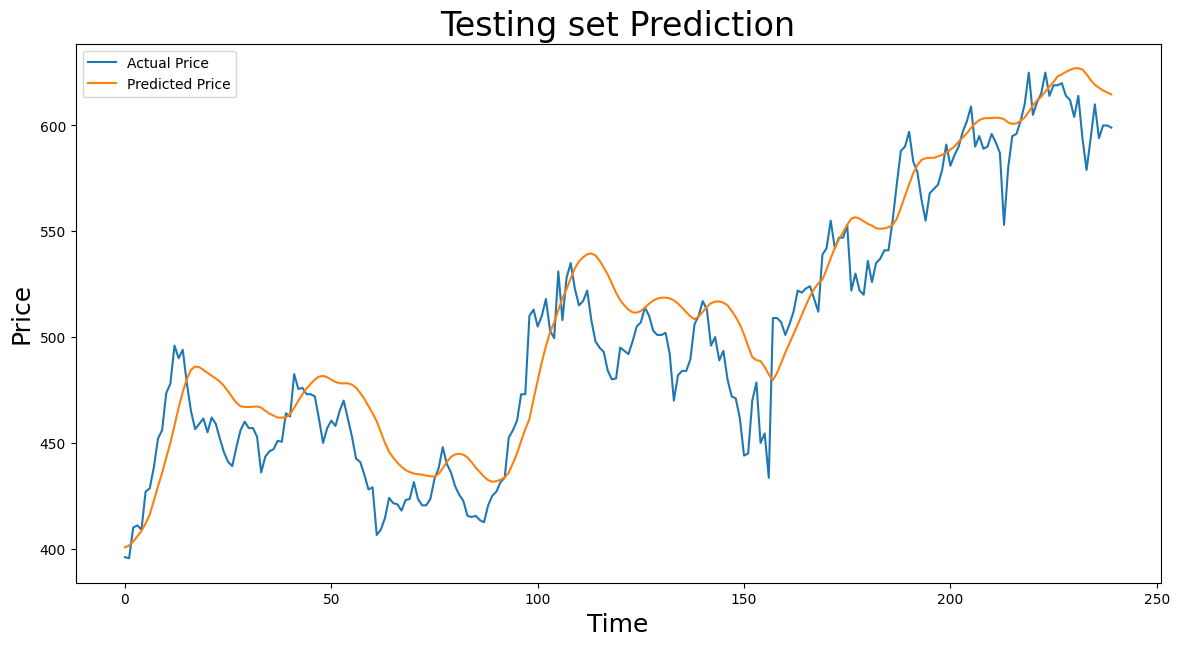

In [15]:
# 保存一些原始數據，用於反標準化時填充其他特徵
original_data_sample = df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].values

# 將預測結果和實際值從tensor轉換為numpy數組
test_outputs = test_outputs.cpu().numpy()
y_test = y_test.cpu().numpy()

# 創建一個與原始數據形狀相同的空陣列
test_outputs_full = np.zeros((test_outputs.shape[0], scaled_data.shape[1]))
y_test_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# 將預測結果和實際值放在適當的位置
test_outputs_full[:, 0] = test_outputs[:, 0]
y_test_full[:, 0] = y_test[:, 0]

# 用原始數據填充其他特徵
test_outputs_full[:, 1:] = original_data_sample[:test_outputs.shape[0], 1:]
y_test_full[:, 1:] = original_data_sample[:y_test.shape[0], 1:]

# 使用 scaler 的 inverse_transform 方法反標準化
test_outputs_original = scaler.inverse_transform(test_outputs_full)[:, 0]
y_test_original = scaler.inverse_transform(y_test_full)[:, 0]

# 繪製實際值和預測值
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual Price')
plt.plot(test_outputs_original, label='Predicted Price')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.title('Testing set Prediction', fontsize=24)
plt.legend()
plt.show()

## 所有資料預測

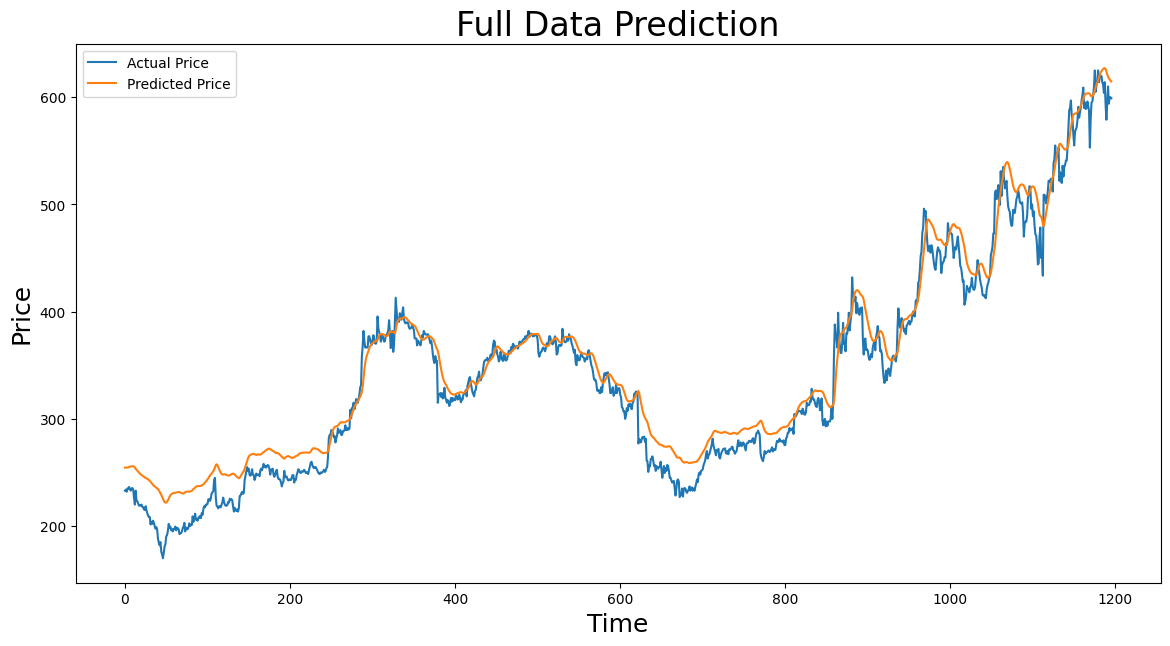

In [16]:
# 將預測結果和實際值從tensor轉換為numpy數組
full_outputs = full_outputs.cpu().numpy()
full_y = full_y.cpu().numpy()

# 創建一個與原始數據形狀相同的空陣列
full_outputs_full = np.zeros((full_outputs.shape[0], scaled_data.shape[1]))
full_y_full = np.zeros((full_y.shape[0], scaled_data.shape[1]))

# 將預測結果和實際值放在適當的位置
full_outputs_full[:, 0] = full_outputs[:, 0]
full_y_full[:, 0] = full_y[:, 0]

# 用原始數據填充其他特徵
full_outputs_full[:, 1:] = original_data_sample[:full_outputs.shape[0], 1:]
full_y_full[:, 1:] = original_data_sample[:full_y.shape[0], 1:]

# 使用 scaler 的 inverse_transform 方法反標準化
full_outputs_original = scaler.inverse_transform(full_outputs_full)[:, 0]
full_y_original = scaler.inverse_transform(full_y_full)[:, 0]

# 繪製實際值和預測值
plt.figure(figsize=(14, 7))
plt.plot(full_y_original, label='Actual Price')
plt.plot(full_outputs_original, label='Predicted Price')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.title('Full Data Prediction', fontsize=24)
plt.legend()
plt.show()

# 應用於股票預測

## Yahoo Finance 下載股票資料

取得距今一個月的股票資料

In [17]:
import yfinance as yf

one_month_data = yf.download('2357.TW', period='1mo')

# 重新命名列
one_month_data.reset_index(inplace=True)  # 將索引重置，將日期作為普通列
one_month_data.columns = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]

print(one_month_data.head())


[*********************100%***********************]  1 of 1 completed

        Date   Open   High    Low  Close  Adj Close   Volume
0 2024-11-11  614.0  614.0  625.0  598.0      625.0  7334281
1 2024-11-12  612.0  612.0  624.0  604.0      605.0  4924370
2 2024-11-13  611.0  611.0  617.0  607.0      611.0  2916339
3 2024-11-14  623.0  623.0  631.0  613.0      615.0  6443141
4 2024-11-15  607.0  607.0  646.0  604.0      625.0  8613115


## 資料前處理

In [18]:
# 將日期轉換為datetime格式
df = one_month_data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-11-11,614.0,614.0,625.0,598.0,625.0,7334281
2024-11-12,612.0,612.0,624.0,604.0,605.0,4924370
2024-11-13,611.0,611.0,617.0,607.0,611.0,2916339
2024-11-14,623.0,623.0,631.0,613.0,615.0,6443141
2024-11-15,607.0,607.0,646.0,604.0,625.0,8613115
2024-11-18,612.0,612.0,623.0,610.0,614.0,11106150
2024-11-19,622.0,622.0,642.0,617.0,619.0,13017100
2024-11-20,619.0,619.0,619.0,619.0,619.0,7000
2024-11-21,610.0,610.0,625.0,610.0,620.0,9250523


## 標準化

In [19]:
# 將數據標準化，並且標準化必須和訓練集的標準化一樣

scaled_data = scaler.transform(df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']])

## 預測

In [ ]:
predict_future_days = 10  # 設定要預測的未來天數

print(f'取得的最新數據日期: {df.index[-1]}，我們將預測下 {predict_future_days} 個交易日的股價')

x, y = create_sequences(scaled_data, seq_length)

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

def rolling_predict(model, initial_sequence, prediction_steps, scaler):
    model.eval()  # 將模型設置為評估模式
    current_sequence = initial_sequence  # 初始化當前序列
    predictions = []  # 用來存儲每一步的預測結果
    
    for _ in range(prediction_steps):  # 遍歷每一步的預測
        with torch.no_grad():  # 在不計算梯度的情況下進行預測
            next_pred = model(current_sequence.unsqueeze(0)).item()  # 獲取下一步的預測值
        predictions.append(next_pred)  # 將預測結果添加到列表中
        
        # 創建一個與初始序列形狀相同的零矩陣，只更新 'Adj Close' 列
        next_pred_scaled = np.zeros((1, initial_sequence.shape[1]))
        next_pred_scaled[0, 0] = next_pred
        
        # 反標準化預測值
        next_pred_scaled = scaler.inverse_transform(next_pred_scaled)
        
        # 獲取反標準化後的 'Adj Close' 值
        next_pred_scaled_value = next_pred_scaled[0, 0]
        
        # 創建新的序列，將當前序列的第一個元素移除，並添加新的預測值
        new_sequence = np.append(current_sequence[1:].numpy(), [[next_pred_scaled_value, 0, 0, 0, 0, 0]], axis=0)
        
        # 更新當前序列
        current_sequence = torch.tensor(new_sequence, dtype=torch.float32)
    
    return predictions  # 返回所有的預測結果

# 使用最後一個訓練序列作為初始序列
initial_sequence = full_x[-1]

# 調用 rolling_predict 函數進行未來股價的預測
future_predictions = rolling_predict(model, initial_sequence, predict_future_days, scaler)

# 創建一個與預測結果長度相同的零矩陣，用於反標準化
future_predictions_scaled = np.zeros((len(future_predictions), scaled_data.shape[1]))

# 將預測結果放入矩陣的 'Adj Close' 列
future_predictions_scaled[:, 0] = future_predictions

# 反標準化所有預測結果
future_predictions_original = scaler.inverse_transform(future_predictions_scaled)[:, 0]

print(future_predictions_original)


取得的最新數據日期: 2024-12-09 00:00:00，我們將預測下 10 個交易日的股價
[614.69565868 605.87755382 592.66072929 583.5644263  577.70604789
 573.41385603 569.95693654 566.90247953 564.09389347 561.28438532]
